# Pytorch를 사용한 QSAR 모델 구축(Prediction)

* python==3.6
* deepchem==2.3.0
* Rdkit==1.1.6
* torch==1.6.0 

Install deepchem library

In [2]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0   7878      0 --:--:-- --:--:-- --:--:--  7878


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [ ]:
!pip install --pre deepchem

In [4]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge python=3.6
!time conda install -q -y -c conda-forge rdkit

done

real	0m44.597s
user	0m38.769s
sys	0m4.635s


In [5]:
import deepchem as dc
dc.__version__

'2.4.0-rc1.dev'

In [6]:
!python --version

Python 3.6.10 :: Anaconda, Inc.


In [7]:
import torch
torch.__version__

'1.6.0+cu101'

In [8]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np

# Pytorch 사용한 QSAR 모델 구축





In [9]:
import torch
torch.__version__

'1.6.0+cu101'

## load to data

In [10]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2020-09-18 03:56:48--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.03s   

2020-09-18 03:56:49 (2.91 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [40]:
#파이썬에서 데이터를 다루기 위한 라이브러리들
import numpy as np
import pandas as pd
#파이썬에서 시각화를 수행해주는 라이브러리
import matplotlib.pyplot as plt
#AI framework torch와 torch의 하위 라이브러리 호출
import torch
import torch.nn as nn
#표준화를 수행하기 위한 라이브러리
from sklearn.preprocessing import StandardScaler
#데이터 분할을 하기 위한 라이브러리
from sklearn.model_selection import train_test_split

data = pd.read_csv("delaney-processed.csv")
data.head(1)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...


,smiles,Molecule
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,

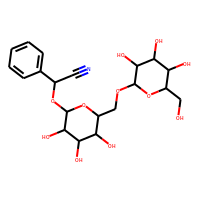

In [12]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data[["smiles","Molecule"]].head(1)

64.0


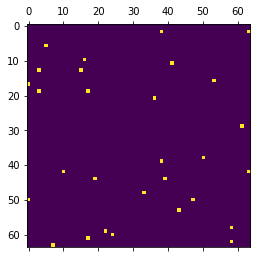

In [13]:
from math import sqrt
print(sqrt(4096))
# https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
def mol2fp(mol):
    #원래 ECFP변환 hash크기는 2048이나 64x64의 크기로 보기위해 늘림
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
fp =mol2fp(Chem.MolFromSmiles(data.loc[1,"smiles"]))
plt.matshow(fp.reshape((64,-1)) >0)

In [14]:
data["FPs"] = data.Molecule.apply(mol2fp)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Molecule,FPs
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

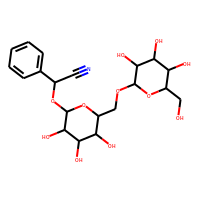
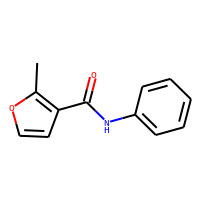
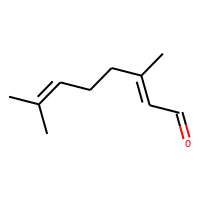
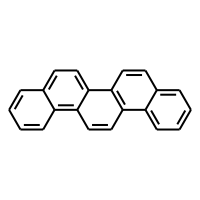
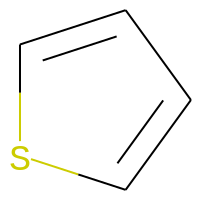
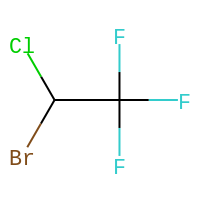
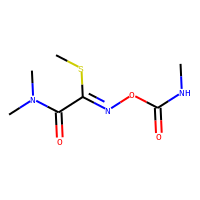
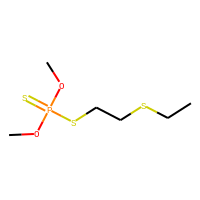
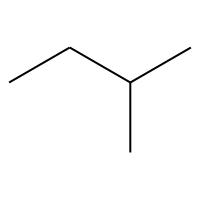
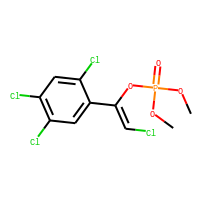

In [15]:
data

## Data Transform

In [16]:
#dataframe에 분할되어 저장되어있는 FPs의 값들은 하나의 np.ndarray에 합치는 함수 np.stack사용
X = np.stack(data.FPs.values)
print(X.shape)
print(X)
print(type(X))

(1128, 4096)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>


In [17]:
print(type(data["measured log solubility in mols per litre"]))

<class 'pandas.core.series.Series'>


In [18]:
y = data["measured log solubility in mols per litre"].values.reshape((-1,1))
print(y)
print(type(y))

[[-0.77 ]
 [-3.3  ]
 [-2.06 ]
 ...
 [-3.091]
 [-3.18 ]
 [-4.522]]
<class 'numpy.ndarray'>


In [19]:
#sklearn의 train_test_splie함수를 사용하여 random하게 데이터를 나눔
#random_state=42로 고정 이 값을 변경할 경우 데이터의 구성이 바뀌니 기억해 둘것
#test_size=0.1로 1을 전체 데이터라고 가정했을때 전체 데이터의 10%를 테스트로 나머지 90% 훈련 데이터로 사용한다는 뜻
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
#splitd을 한번더 수행 이러한 이유는 valid 데이터를 수행하기 위함임 train 데이터의 10%를 valid 데이터로 생성
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.1, random_state=42)
#정규화 수행 [0,1]의 값으로 
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [21]:
# cpu에서 학습
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
X_validation = torch.tensor(X_validation).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
y_validation = torch.tensor(y_validation).float()
X_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct 

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [23]:
X_train.shape, X_validation.shape, X_test.shape

(torch.Size([913, 4096]), torch.Size([102, 4096]), torch.Size([113, 4096]))

In [24]:
y_train.shape

torch.Size([913, 1])

In [25]:
#TensorDataset을 사용하여 입력과 출력 쌍을 묶어줌
#이는 torch의 데이터로더함수를 사용하여 batch크기만큼 입력 출력쌍을 주기 위함
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [26]:
#DataLoader를 사용하여 전체 train, valid 데이터를 배치크기로 분할하면서 섞어주는 작업을 수행함 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=True)

## DNN Model

In [27]:
#나만의 딥러닝 모델 구축
#nn.XXX로 레이어를 추가할 수 있음
#예제의 모델은 (Linear, LayerNorm, ReLU, Dropout)이 한쌍으로 3번 반복되게 구성한 모델임
#단순 Linear 레이어를 쌓았지만 일반화를 위하여 LayerNorm, Dropout을 사용하였음

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(MLPModel, self).__init__()
        # 3개의 fully connected Linear layer를 사용
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer      
        #ReLU 활성화 함수 추가
        self.activation = nn.ReLU()
        #Dropout 일반화 부분
        self.dropout = nn.Dropout(dropout_rate)
    #실제 학습시 레이어 사용 부분 
    def forward(self, x):
        out = self.linear1(x)
        out = self.activation(out)
        out = self.dropout(out)
        #1 block
        out = self.linear2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.linear3(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        #Final output layer 1
        out = self.fc_out(out)
        return out

In [28]:
X_train.size()

torch.Size([913, 4096])

In [29]:
#하이퍼 파라미터 세팅
input_size = X_train.size()[-1]     #입력 데이터 크기 size
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.8   # The dropout rate
output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.001  # The learning rate for the optimizer

model = MLPModel(input_size, hidden_size, dropout_rate, output_size)
model

MLPModel(
  (linear1): Linear(in_features=4096, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
)

In [ ]:
from IPython.display import Image
Image(url='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fk5Ch3%2FbtqDL4jjXl1%2F93WikBjXpxJ0e7kYy8c8SK%2Fimg.gif')

In [30]:
#Loss function과 optimizer를 설정
#Loss function은 Mean Squared Error로
#Optimizer는 Adam으로
#pytorch Loss function: https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [31]:
#cpu 모드
from sklearn.metrics import r2_score
import timeit
start_time = timeit.default_timer()
list_epoch = []
list_train_loss = []
list_val_loss = []
list_r2 = []
epochs = 200
for e in range(epochs):
    running_loss = 0
    for X, y in train_loader:
        model.train() #학습 모드로 변경
        optimizer.zero_grad() # 그라디언트 값을 0으로 초기화
        #print(X.shape, y.shape)# 256
        output = model(X) #배치단위별로 학습
        loss = criterion(output, y) #loss를 Lossfunction을 사용하여 구하는 부분
        loss.backward() # backward를 통해서 그라디언트를 구해줌 optimizer가 감당할 파라미터들을 사용하여 미분을 수행함
        optimizer.step() # step을 통해서 그라디언트를 바탕으로 파라미터 업데이트
        running_loss += loss
    else:
        if e%50 == 0:
          #mse
          validation_loss =torch.mean((y_validation-model(X_validation))**2)
          list_r2.append(r2_score(y_validation.detach(), model(X_validation).detach()))
          list_epoch.append(e)
          list_train_loss.append(running_loss/len(train_loader))

          print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))
          list_val_loss.append(validation_loss)
terminate_time = timeit.default_timer()
print("%f초 걸렸습니다."% (terminate_time-start_time))

Epoch:   0 Training loss: 0.96 Validation loss: 0.94
Epoch:  50 Training loss: 0.09 Validation loss: 0.23
Epoch: 100 Training loss: 0.09 Validation loss: 0.24
Epoch: 150 Training loss: 0.09 Validation loss: 0.23
147.760865초 걸렸습니다.


## DNN 모델의 성능평가

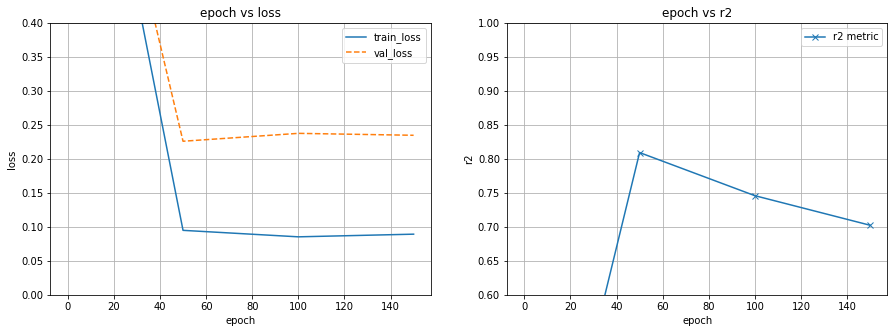

In [32]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 0.4)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_r2, marker='x', label='r2 metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('r2')
ax2.set_ylim(0.6, 1.0)
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs r2')

plt.show()

epoch당 loss 그래프와 epoch당 r2 그래프를 살펴보고 성능평가 및 에포크 수 결정 

In [35]:
#evaluation mode로 전환
model.eval()
#학습한 모델에 각 데이터의 입력을 주어 예측값들을 생성
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

In [36]:
#test 데이터셋의 RMSE와 R2점수 구하기 
print("RMSE: {0:.3f}".format(torch.sqrt(torch.mean(( y_test - y_pred_test )**2)).detach()))
print("r2_score: {0:.3f}".format(r2_score(y_test.detach() , y_pred_test.detach())))

RMSE: 0.577
r2_score: 0.729


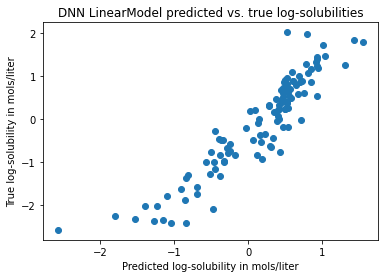

In [37]:
plt.scatter(y_pred_test.detach(), y_test.detach())
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'DNN LinearModel predicted vs. true log-solubilities')
plt.show()

CPU를 사용하는 예제와 GPU를 사용하는 예제간 충돌이 발생하여 illegal CUDA 에러가 발생한다면 아래의 셀부터 실행하면됩니다.

# Pytorch GPU사용하기

## load to data

In [38]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2020-09-18 04:06:19--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv.1’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.03s   

2020-09-18 04:06:19 (2.88 MB/s) - ‘delaney-processed.csv.1’ saved [96699/96699]



In [42]:
#파이썬에서 데이터를 다루기 위한 라이브러리들
import numpy as np
import pandas as pd
#파이썬에서 시각화를 수행해주는 라이브러리
import matplotlib.pyplot as plt
#AI framework torch와 torch의 하위 라이브러리 호출
import torch
import torch.nn as nn
#표준화를 수행하기 위한 라이브러리
from sklearn.preprocessing import StandardScaler
#데이터 분할을 하기 위한 라이브러리
from sklearn.model_selection import train_test_split

data = pd.read_csv("delaney-processed.csv")

## Data Transform

In [43]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from math import sqrt
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
def mol2fp(mol):
    #원래 ECFP변환 hash크기는 2048이나 64x64의 크기로 보기위해 늘림
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
fp =mol2fp(Chem.MolFromSmiles(data.loc[1,"smiles"]))
data["FPs"] = data.Molecule.apply(mol2fp)

In [44]:
X = np.stack(data.FPs.values)
y = data["measured log solubility in mols per litre"].values.reshape((-1,1))

In [45]:
#sklearn의 train_test_splie함수를 사용하여 random하게 데이터를 나눔
#random_state=42로 고정 이 값을 변경할 경우 데이터의 구성이 바뀌니 기억해 둘것
#test_size=0.1로 1을 전체 데이터라고 가정했을때 전체 데이터의 10%를 테스트로 나머지 90% 훈련 데이터로 사용한다는 뜻
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
#splitd을 한번더 수행 이러한 이유는 valid 데이터를 수행하기 위함임 train 데이터의 10%를 valid 데이터로 생성
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.1, random_state=42)
#정규화 수행 [0,1]의 값으로 
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [46]:
# gpu에서 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cuda:0


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

## GPU DNN Model

In [48]:
#나만의 딥러닝 모델 구축
#nn.XXX로 레이어를 추가할 수 있음
#예제의 모델은 (Linear, LayerNorm, ReLU, Dropout)이 한쌍으로 3번 반복되게 구성한 모델임
#단순 Linear 레이어를 쌓았지만 일반화를 위하여 LayerNorm, Dropout을 사용하였음
class cudaMLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(cudaMLPModel, self).__init__()
        # 3개의 fully connected Linear layer를 사용
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer      
        #ReLU 활성화 함수 추가
        self.activation = nn.ReLU()
        #Dropout 일반화 부분
        self.dropout = nn.Dropout(dropout_rate)
    #실제 학습시 레이어 사용 부분 
    def forward(self, x):
        out = self.linear1(x)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.linear3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

In [50]:
#하이퍼 파라미터 세팅
input_size = X_train.size()[-1]     # fp의 길이를 획득
hidden_size = 1024   # 은닉 계층의 크기
dropout_rate = 0.8   # 드롭아웃 비율
output_size = 1        # 학습의 마지막에 출력할 값의 갯수 
learning_rate = 0.0001  # optimizer에 대한 learning rate

cudamodel = cudaMLPModel(input_size, hidden_size, dropout_rate, output_size)

In [51]:
#학습 모델이 GPU를 사용한다는 표시
cudamodel.cuda()

cudaMLPModel(
  (linear1): Linear(in_features=4096, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
)

In [52]:
#TensorDataset을 사용하여 입력과 출력 쌍을 묶어줌
#이는 torch의 데이터로더함수를 사용하여 batch크기만큼 입력 출력x쌍을 주기 위함
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [53]:
#DataLoader를 사용하여 전체 train, valid 데이터를 배치크기로 분할하면서 섞어주는 작업을 수행함 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=True)

In [54]:
#Loss function과 optimizer를 설정
criterion2 = nn.MSELoss()
#weight_decay=0
optimizer2 = torch.optim.Adam(cudamodel.parameters(), lr=learning_rate)

## Training

In [55]:
#gpu모드
from sklearn.metrics import r2_score
import timeit
start_time = timeit.default_timer()
list_epoch = []
list_train_loss = []
list_val_loss = []
list_r2 = []
cudamodel.train()
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer2.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = cudamodel(fps) #Forward pass of the mini-batch
        loss = criterion2(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer2.step() # Optimize the weights
        running_loss += loss.item()
    else:
        if e%50 == 0:
            validation_loss = torch.mean(( y_validation - cudamodel(X_validation) )**2).item()
            list_r2.append(r2_score(y_validation.detach().cpu(), cudamodel(X_validation).detach().cpu()))
            list_epoch.append(e)
            list_train_loss.append(running_loss/len(train_loader))

            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))
            list_val_loss.append(validation_loss)
terminate_time = timeit.default_timer()
print("%f초 걸렸습니다."% (terminate_time-start_time))

Epoch:   0 Training loss: 0.99 Validation loss: 1.13
Epoch:  50 Training loss: 0.18 Validation loss: 0.30
Epoch: 100 Training loss: 0.08 Validation loss: 0.25
Epoch: 150 Training loss: 0.06 Validation loss: 0.23
4.245908초 걸렸습니다.


## GPU DNN 모델의 성능평가

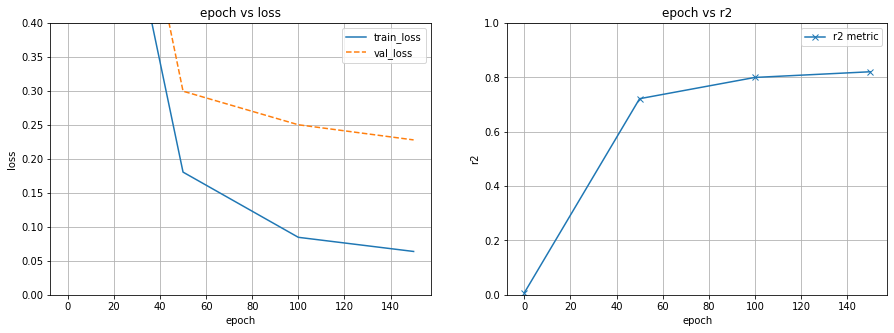

In [56]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 0.4)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_r2, marker='x', label='r2 metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('r2')
ax2.set_ylim(0, 1.0)
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs r2')


plt.show()

In [86]:
#evaluation mode로 전환
cudamodel.eval()
y_pred_train = cudamodel(X_train)
y_pred_validation = cudamodel(X_validation)
y_pred_test = cudamodel(X_test)

RuntimeError: ignored

In [87]:
#test 데이터셋의 MSE와 R2점수 구하기 
#test 데이터셋의 RMSE와 R2점수 구하기 
print("RMSE: {0:.3f}".format(torch.sqrt(torch.mean(( y_test - y_pred_test )**2)).item()))
print("r2_score: {0:.3f}".format(r2_score(y_test.detach().cpu().clone() , y_pred_test.detach().cpu().clone())))

RMSE: 0.415
r2_score: 0.860


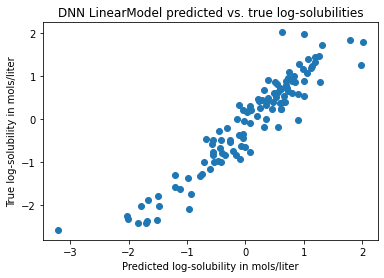

In [59]:
plt.scatter(y_pred_test.detach().cpu().clone(), y_test.detach().cpu().clone())
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'DNN LinearModel predicted vs. true log-solubilities')
plt.show()

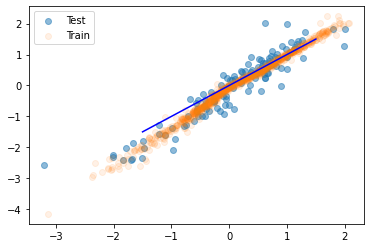

In [60]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()
    
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")
plt.show()

In [61]:
#정확한 값 예측을 위해 다음과 같이 inverse_transform을 사용
def predict_smiles(smiles):
    #모델에 찾고자하는 smiles를 입력으로 주면 Smiles를 fingerprint로 변형
    fp =mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    #fp를 torch.tensor입력으로 변환gpu사용하는 경우
    fp_tensor = torch.tensor(fp, device=device).float()
    #모델에 변형한 입력을 줌
    prediction = cudamodel(fp_tensor)
    #return prediction.cpu().detach().numpy()
    #모델 학습 시 입력 및 출력 데이터를 transform하였기에 inverse_transform을 사용하여 원본 값의 범위로 재조정하여 예측값 출력
    logP = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return logP[0][0]
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

-3.511628

# 하이퍼 파라미터 Grid Search

## load to data

In [62]:
data = pd.read_csv("delaney-processed.csv")

## Data Transform

In [63]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from math import sqrt
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
def mol2fp(mol):
    #원래 ECFP변환 hash크기는 2048이나 64x64의 크기로 보기위해 늘림
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
fp =mol2fp(Chem.MolFromSmiles(data.loc[1,"smiles"]))
data["FPs"] = data.Molecule.apply(mol2fp)

In [64]:
X = np.stack(data.FPs.values)
y = data["measured log solubility in mols per litre"].values.reshape((-1,1))

In [66]:
#sklearn의 train_test_splie함수를 사용하여 random하게 데이터를 나눔
#random_state=42로 고정 이 값을 변경할 경우 데이터의 구성이 바뀌니 기억해 둘것
#test_size=0.1로 1을 전체 데이터라고 가정했을때 전체 데이터의 10%를 테스트로 나머지 90% 훈련 데이터로 사용한다는 뜻
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
#splitd을 한번더 수행 이러한 이유는 valid 데이터를 수행하기 위함임 train 데이터의 10%를 valid 데이터로 생성
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.1, random_state=42)
#정규화 수행 [0,1]의 값으로 y값에 대해서만 정규화 수행
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [67]:
# gpu에서 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cuda:0


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [68]:
    #TensorDataset을 사용하여 입력과 출력 쌍을 묶어줌
    #이는 torch의 데이터로더함수를 사용하여 batch크기만큼 입력 출력쌍을 주기 위함
    from torch.utils.data import TensorDataset
    train_dataset = TensorDataset(X_train, y_train)
    validation_dataset = TensorDataset(X_validation, y_validation)

    #DataLoader를 사용하여 전체 train, valid 데이터를 배치크기로 분할하면서 섞어주는 작업을 수행함 
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=256,
                                              shuffle=True)
    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                              batch_size=256,
                                              shuffle=True)

## Training & Tuning Hyper-parameter

In [69]:
from sklearn.metrics import r2_score
from itertools import product
#하이퍼 파라미터 세팅
input_size = X_train.size()[-1]     #fingerprint size를 얻어오는 코드
hidden_size = 1024   #히든 레이어 크기
output_size = 1        # 1개의 숫자를 예측하기 때문에 output의 크기를 1로 설정

parameters = dict(
    learning_rates = [0.001,0.0001]
    ,dropout_rates= [0.8,0.5]
    ,epochs=[200,300]
    ,hidden_size=[512,1024]
)
param_values = [v for v in parameters.values()]
param_values
prev_score = 0.0
best_param=[]
for lr, dropout_rate, epochs, hidden_size in product(*param_values):
    grid_model = MLPModel(input_size, hidden_size, dropout_rate, output_size)
    grid_model.cuda()

    criterion3 = nn.MSELoss()
    optimizer3 = torch.optim.Adam(grid_model.parameters(), lr=lr)
    grid_model.train() #모델은 train mode로 설정
    epochs = epochs

    for e in range(epochs+1):
        running_loss = 0
        for fps, labels in train_loader:
            # Training pass
            optimizer3.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
            output = grid_model(fps) #Forward pass of the mini-batch
            loss = criterion3(output, labels) #Computing the loss
            loss.backward() # calculate the backward pass
            optimizer3.step() # Optimize the weights
            running_loss += loss.item()
        else:
            if e%100 == 0:
                validation_loss = torch.mean(( y_validation - grid_model(X_validation) )**2).item()
                print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))
                #list_val_loss.append(validation_loss)
            if e == epochs:
              score = r2_score(y_validation.detach().cpu(), grid_model(X_validation).detach().cpu())
              print("lr:", lr, "dropout_rate:", dropout_rate, "epochs:",epochs, "validation_loss:",validation_loss, "r2_score:", score)
              if prev_score < score:
                prev_score=score
                best_param={'lr':lr, 'dropout_rate':dropout_rate, 'epochs':epochs, 'r2_score':score}

Epoch:   0 Training loss: 0.98 Validation loss: 1.00
Epoch: 100 Training loss: 0.10 Validation loss: 0.33
Epoch: 200 Training loss: 0.09 Validation loss: 0.31
lr: 0.001 dropout_rate: 0.8 epochs: 200 validation_loss: 0.3050367832183838 r2_score: 0.7527065634472359
Epoch:   0 Training loss: 0.95 Validation loss: 0.93
Epoch: 100 Training loss: 0.08 Validation loss: 0.26
Epoch: 200 Training loss: 0.07 Validation loss: 0.28
lr: 0.001 dropout_rate: 0.8 epochs: 200 validation_loss: 0.2769334316253662 r2_score: 0.7793446583386264
Epoch:   0 Training loss: 0.98 Validation loss: 1.03
Epoch: 100 Training loss: 0.09 Validation loss: 0.27
Epoch: 200 Training loss: 0.09 Validation loss: 0.26
Epoch: 300 Training loss: 0.09 Validation loss: 0.28
lr: 0.001 dropout_rate: 0.8 epochs: 300 validation_loss: 0.27597883343696594 r2_score: 0.7501550491525978
Epoch:   0 Training loss: 0.96 Validation loss: 0.91
Epoch: 100 Training loss: 0.09 Validation loss: 0.27
Epoch: 200 Training loss: 0.09 Validation loss: 

In [70]:
print(best_param)

{'lr': 0.0001, 'dropout_rate': 0.5, 'epochs': 200, 'r2_score': 0.8448392696997479}


# Convolutional Neural Network

## load to data

In [71]:
data = pd.read_csv("delaney-processed.csv")


## Data Tansform

In [72]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from math import sqrt
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
def mol2fp(mol):
    #원래 ECFP변환 hash크기는 2048이나 64x64의 크기로 보기위해 늘림
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
fp =mol2fp(Chem.MolFromSmiles(data.loc[1,"smiles"]))
data["FPs"] = data.Molecule.apply(mol2fp)

In [73]:
#dataframe에 분할되어 저장되어있는 FPs의 값들은 하나의 np.ndarray에 합치는 함수 np.stack사용
#합친 결과를 (1128,1, 64,64)로 모양 수정 CNN입력인 4차원으로 주기 위함
X = np.stack(data.FPs.values)
X = X.reshape(len(X),1,64,-1)
print(X.shape)
print(X)

(1128, 1, 64, 64)
[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 1]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 ...


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]]


In [74]:
y = data["measured log solubility in mols per litre"].values.reshape((-1,1))
print(y)
print(type(y))

[[-0.77 ]
 [-3.3  ]
 [-2.06 ]
 ...
 [-3.091]
 [-3.18 ]
 [-4.522]]
<class 'numpy.ndarray'>


In [75]:
#sklearn의 train_test_split함수를 사용하여 random하게 데이터를 나눔
#random_state=42로 고정 이 값을 변경할 경우 데이터의 구성이 바뀌니 기억해 둘것
#test_size=0.1로 1을 전체 데이터라고 가정했을때 전체 데이터의 10%를 테스트로 나머지 90% 훈련 데이터로 사용한다는 뜻
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
#splitd을 한번더 수행 이러한 이유는 valid 데이터를 수행하기 위함임 train 데이터의 10%를 valid 데이터로 생성
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.1, random_state=42)
#정규화 수행 [0,1]의 값으로 
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [76]:
print(X_train.shape, X_validation.shape, X_test.shape)

(913, 1, 64, 64) (102, 1, 64, 64) (113, 1, 64, 64)


In [77]:
#랜덤 시드 고정
torch.manual_seed(42)
# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42)
# gpu에서 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cuda:0


tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 1.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [78]:
#TensorDataset을 사용하여 입력과 출력 쌍을 묶어줌
#이는 torch의 데이터로더함수를 사용하여 batch크기만큼 입력 출력쌍을 주기 위함
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [79]:
#DataLoader를 사용하여 전체 train, valid 데이터를 배치크기로 분할하면서 섞어주는 작업을 수행함 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=True)

In [80]:
#나만의 딥러닝 모델 구축
#nn.XXX로 레이어를 추가할 수 있음
#예제의 모델은 CNN모델을 사용하기 위해 Conv2d relue, max_pool2d가 하나의 컬렉션으로 구성되어 2번을 반복하고 마지막 fc레이어를 구성한 값이 됨
#단순 Linear 레이어를 쌓았지만 일반화를 위하여 LayerNorm, Dropout을 사용하였음
class CNNModel(nn.Module):
    def __init__(self,):
        super(CNNModel, self).__init__()
        #cnn layer
        # 64* 64 = 3filter padding 1 stride =1 (64-3+2*1+1)/1= 64
        self.conv1 = nn.Conv2d(1,6,kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(6,16,kernel_size=3, padding=1)
        #activation function
        self.relu = nn.ReLU()
        #pooling layer
        self.maxpool = nn.MaxPool2d(2)
        #dropout layer
        self.dropout1 = nn.Dropout2d(0.2)
        #fully connect layer
        self.fc1 = nn.Linear(16 * 16 * 16, 1024) 
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)
     
    def forward(self, x):# Forward pass: stacking each layer together
        #input Shape (batch_size,1,64,64)
        #convol(batch_size,6,64,64)
        #pooling (batch_size,6,32,32) 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #convol(batch_size,6,32,32)
        #pooling (batch_size,16,16,16)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        #1자로 inputshape를 펴주는 과정
        x = x.view(x.size(0),-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x  

In [81]:
#하이퍼 파라미터 세팅
#input_size = X_train.size()[-1]     # The input size should fit our fingerprint size
#hidden_size = 1024   # The size of the hidden layer
#dropout_rate = 0.2   # The dropout rate
#output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.0001  # The learning rate for the optimizer

cnnmodel = CNNModel()
print(cnnmodel)

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [82]:
cnnmodel.cuda()

CNNModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)

In [83]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnnmodel.parameters(), lr=learning_rate)

## Training

In [84]:
from sklearn.metrics import r2_score

list_epoch = []
list_train_loss = []
list_val_loss = []
list_train_r2 = []
list_val_r2 = []
cnnmodel.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = cnnmodel(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
        running_loss += loss.item()
    else:
        if e%50 == 0:
            validation_loss = torch.mean(( y_validation - cnnmodel(X_validation) )**2).item()
            list_train_r2.append(r2_score(y_train.detach().cpu(), cnnmodel(X_train).detach().cpu()))
            list_val_r2.append(r2_score(y_validation.detach().cpu(), cnnmodel(X_validation).detach().cpu()))
            list_epoch.append(e)
            list_train_loss.append(running_loss/len(train_loader))

            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))
            list_val_loss.append(validation_loss)

Epoch:   0 Training loss: 0.97 Validation loss: 1.00
Epoch:  50 Training loss: 0.11 Validation loss: 0.21
Epoch: 100 Training loss: 0.05 Validation loss: 0.20
Epoch: 150 Training loss: 0.03 Validation loss: 0.19


## CNN 모델의 성능평가

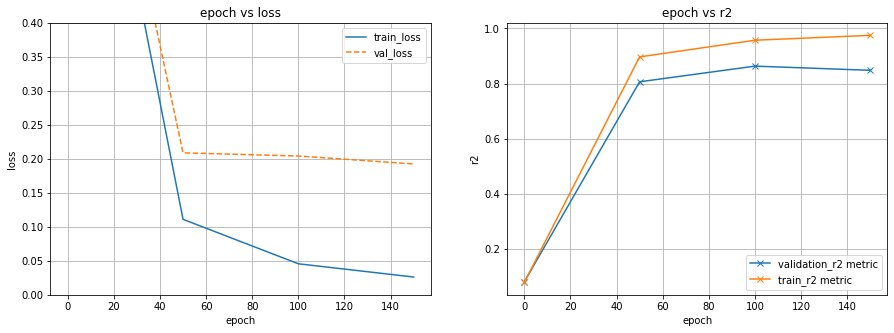

In [85]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 0.4)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_val_r2, marker='x', label='validation_r2 metric')
ax2.plot(list_epoch, list_train_r2, marker='x', label='train_r2 metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('r2')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs r2')


plt.show()

In [88]:
cnnmodel.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = cnnmodel(X_train)
y_pred_validation = cnnmodel(X_validation)
y_pred_test = cnnmodel(X_test)

In [89]:
#test 데이터셋의 RMSE와 R2점수 구하기 
print("RMSE: {0:.3f}".format(torch.sqrt(torch.mean(( y_test - y_pred_test )**2)).item()))
print("r2_score: {0:.3f}".format(r2_score(y_test.detach().cpu().clone() , y_pred_test.detach().cpu().clone())))

RMSE: 0.350
r2_score: 0.900


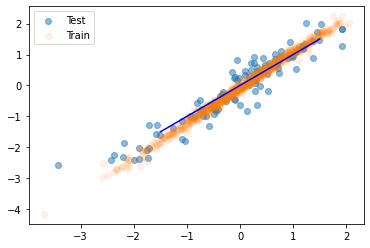

In [90]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()
    
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

# Mol2Vec사용한 모델 구축

In [91]:
#파이썬 외 외부 라이브러리 중 github의 라이브러리를 불러올때 아래와 같이 설치하면
#깃허브에 접속하면 설치법을 안내해줌
!pip install git+https://github.com/samoturk/mol2vec

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-cexzjleh
     |████████████████████████████████| 24.2 MB 86 kB/s 
     |████████████████████████████████| 300 kB 48.2 MB/s 
     |████████████████████████████████| 11.6 MB 128 kB/s 
     |████████████████████████████████| 785 kB 48.5 MB/s 
     |████████████████████████████████| 283 kB 46.3 MB/s 
     |████████████████████████████████| 25.9 MB 38 kB/s 
     |████████████████████████████████| 111 kB 52.0 MB/s 
     |████████████████████████████████| 88 kB 6.8 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 355 kB 44.0 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 944 kB 37.4 MB/s 
     |████████████████████████████████| 1.4 MB 46.2 MB/s 
     |████████████████████████████████| 1.4 MB 42.0 MB/s 
     |████████████████████████████████| 129 kB 54.9 MB/s 
     

## load to data

In [93]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2020-09-18 04:23:00--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv.3’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.03s   

2020-09-18 04:23:00 (3.04 MB/s) - ‘delaney-processed.csv.3’ saved [96699/96699]



In [94]:
import pandas as pd
data = pd.read_csv("delaney-processed.csv")
data.head(1)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...


## Data Transform

,smiles,Molecule
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,

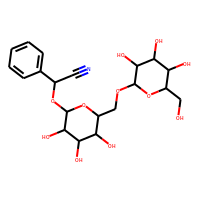

In [95]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(data,'smiles','Molecule')
data[["smiles","Molecule"]].head(1)

In [96]:
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [97]:
aas = [Chem.MolFromSmiles(x) for x in data["smiles"]]

In [98]:
sentence=mol2alt_sentence(aas[0],1)
sentence

['864662311',
 '1535166686',
 '2245384272',
 '3153477100',
 '2976033787',
 '1916236386',
 '3189457552',
 '2667063169',
 '2976033787',
 '1286704427',
 '864674487',
 '1759589175',
 '2245384272',
 '3129492592',
 '2976033787',
 '1916236386',
 '3189457552',
 '2667063169',
 '2976033787',
 '1286704427',
 '864674487',
 '199163361',
 '2245273601',
 '3147100053',
 '2245900962',
 '869152089',
 '847433064',
 '2551483158',
 '3217380708',
 '3579962709',
 '3218693969',
 '951226070',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '98513984',
 '3218693969',
 '951226070',
 '2976033787',
 '675765711',
 '864662311',
 '266675433',
 '2976033787',
 '675765711',
 '864662311',
 '266675433',
 '2976033787',
 '675765711',
 '864662311',
 '266675433',
 '2976033787',
 '675765711',
 '864662311',
 '266675433',
 '2976033787',
 '675765711',
 '864662311',
 '266675433',
 '2976033787',
 '675765711',
 '864662311',
 '266675433']

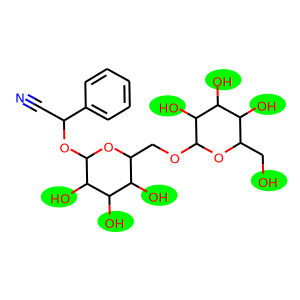

In [99]:
depict_identifier(aas[0], 864662311, 1)

In [100]:
it = IdentifierTable(sentence, [aas[0]]*len(sentence), [sentence]*len(sentence), 5, 1)
it

In [101]:
from gensim.models import word2vec

구글 드라이브에 데이터를 올리는 법: 아래의 그림

필요한 파일 model_300dim.pkl 위치 : https://github.com/samoturk/mol2vec/tree/master/examples/models

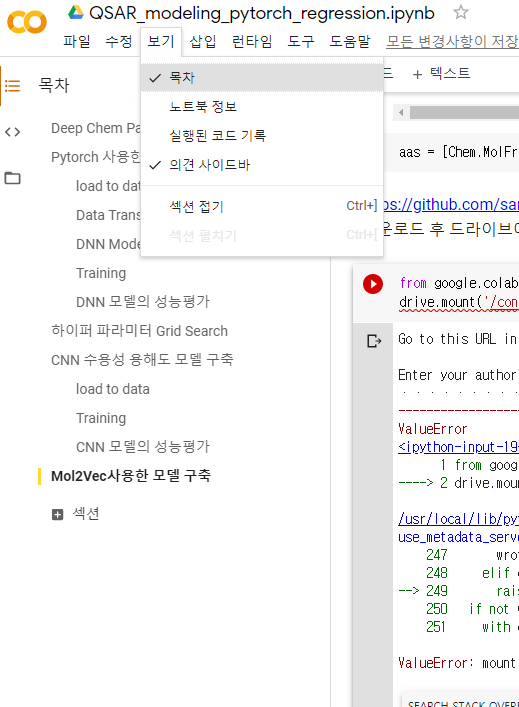

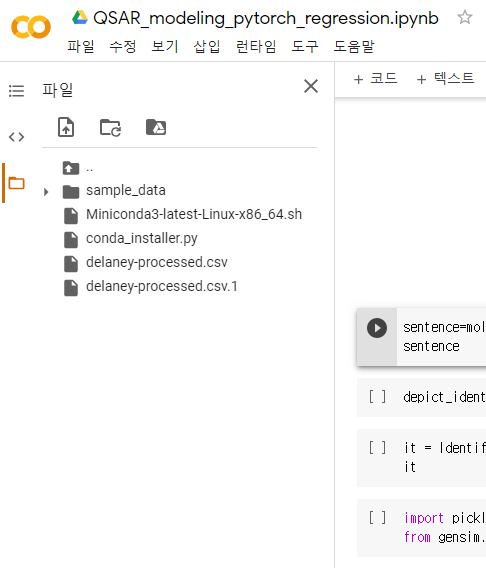

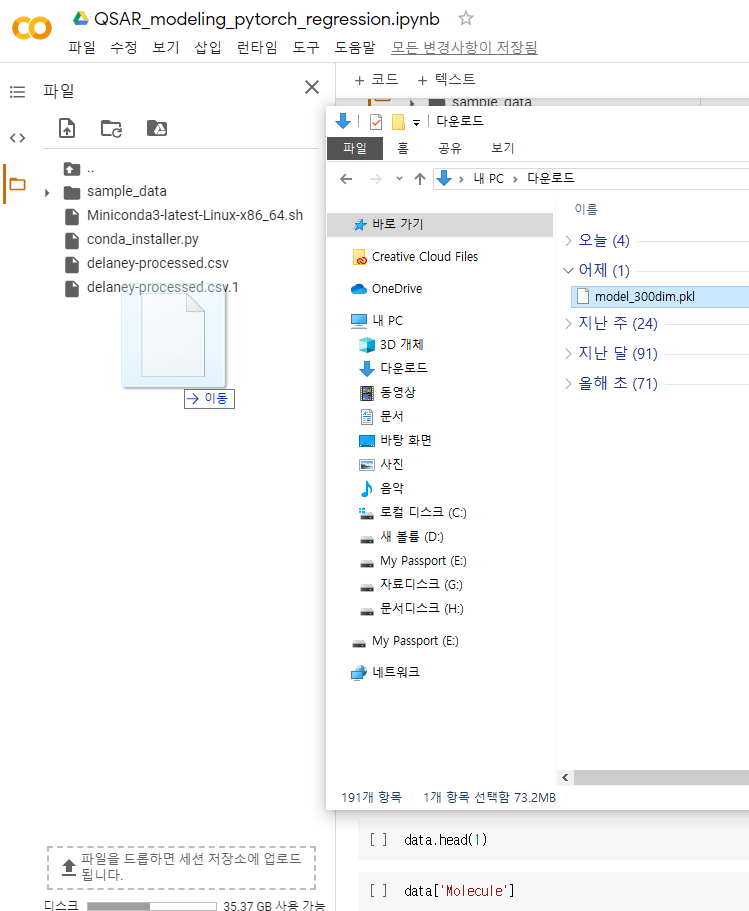

github에 있는 model_300dim.pkl을 한번에 받아오는 코드

In [103]:
!wget https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl

--2020-09-18 04:26:34--  https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76786055 (73M) [application/octet-stream]
Saving to: ‘model_300dim.pkl.1’

model_300dim.pkl.1  100%[===================>]  73.23M  73.9MB/s    in 1.0s    

2020-09-18 04:26:35 (73.9 MB/s) - ‘model_300dim.pkl.1’ saved [76786055/76786055]



In [104]:
w2vmodel = word2vec.Word2Vec.load('model_300dim.pkl')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [105]:
#Number of unique identifiers represented as vectors
len(w2vmodel.wv.vocab.keys())

21003

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Molecule
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,

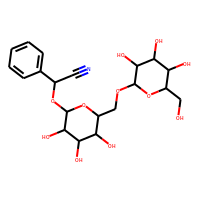

In [107]:
data.head(1)

In [108]:
data['Molecule']

0       <img data-content="rdkit/molecule" src="data:i...
1       <img data-content="rdkit/molecule" src="data:i...
2       <img data-content="rdkit/molecule" src="data:i...
3       <img data-content="rdkit/molecule" src="data:i...
4       <img data-content="rdkit/molecule" src="data:i...
                              ...                        
1123    <img data-content="rdkit/molecule" src="data:i...
1124    <img data-content="rdkit/molecule" src="data:i...
1125    <img data-content="rdkit/molecule" src="data:i...
1126    <img data-content="rdkit/molecule" src="data:i...
1127    <img data-content="rdkit/molecule" src="data:i...
Name: Molecule, Length: 1128, dtype: object

In [109]:
data['sentence'] = data.apply(lambda x: MolSentence(mol2alt_sentence(x['Molecule'], 1)), axis=1)

In [110]:
data['mol2vec'] = [DfVec(x) for x in sentences2vec(data['sentence'], w2vmodel, unseen='UNK')]

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,Molecule,sentence,mol2vec
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,,"(864662311, 1535166686, 2245384272, 3153477100...","(300,) dimensional vector"

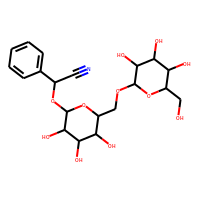

In [111]:
data.head(1)

In [112]:
X = np.array([x.vec for x in data['mol2vec']])
y = data['measured log solubility in mols per litre'].values.reshape((-1,1))

In [113]:
#sklearn의 train_test_splie함수를 사용하여 random하게 데이터를 나눔
#random_state=42로 고정 이 값을 변경할 경우 데이터의 구성이 바뀌니 기억해 둘것
#test_size=0.1로 1을 전체 데이터라고 가정했을때 전체 데이터의 10%를 테스트로 나머지 90% 훈련 데이터로 사용한다는 뜻
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
#splitd을 한번더 수행 이러한 이유는 valid 데이터를 수행하기 위함임 train 데이터의 10%를 valid 데이터로 생성
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.1, random_state=42)
#정규화 수행 [0,1]의 값으로 
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [114]:
# gpu에서 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cuda:0


tensor([[  0.6398,   1.5559,  -1.5355,  ...,  -2.2593,  -3.9086,   0.4851],
        [ -1.5316,  -7.9163,  -6.0273,  ...,  -2.4850, -12.4975,   3.9382],
        [  0.9494,  -0.9584,  -0.5601,  ...,  -4.1352,  -6.4839,  -1.8985],
        ...,
        [ -1.5671,  -0.0286,  -0.9324,  ...,   1.1181,  -1.1595,  -1.1114],
        [ -1.1879,  -6.7705,  -6.3758,  ...,  -3.3778, -14.5161,  -0.0831],
        [  1.5110,  -3.0176,  -2.8297,  ...,  -4.9359,  -8.8553,  -2.0444]],
       device='cuda:0')

In [115]:
print(X_train.shape, y_train.shape)

torch.Size([913, 300]) torch.Size([913, 1])


In [116]:
#TensorDataset을 사용하여 입력과 출력 쌍을 묶어줌
#이는 torch의 데이터로더함수를 사용하여 batch크기만큼 입력 출력쌍을 주기 위함
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [117]:
#DataLoader를 사용하여 전체 train, valid 데이터를 배치크기로 분할하면서 섞어주는 작업을 수행함 
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=False)

In [119]:
#하이퍼 파라미터 세팅
input_size = X_train.size()[-1]     # The input size should fit our fingerprint size
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.8   # The dropout rate
output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.0001  # The learning rate for the optimizer

vec_dnn_model = MLPModel(input_size, hidden_size, dropout_rate, output_size)

In [120]:
vec_dnn_model.cuda()

MLPModel(
  (linear1): Linear(in_features=300, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
)

In [121]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vec_dnn_model.parameters(), lr=learning_rate)

## Training 

In [122]:
from sklearn.metrics import r2_score

list_epoch = []
list_train_loss = []
list_val_loss = []
list_r2 = []
vec_dnn_model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 400
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = vec_dnn_model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
        running_loss += loss.item()
    else:
        if e%100 == 0:
            validation_loss = torch.mean(( y_validation - vec_dnn_model(X_validation) )**2).item()
            list_r2.append(r2_score(y_validation.detach().cpu(), vec_dnn_model(X_validation).detach().cpu()))
            list_epoch.append(e)
            list_train_loss.append(running_loss/len(train_loader))

            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))
            list_val_loss.append(validation_loss)

Epoch:   0 Training loss: 2.87 Validation loss: 2.10
Epoch: 100 Training loss: 0.59 Validation loss: 0.52
Epoch: 200 Training loss: 0.35 Validation loss: 0.38
Epoch: 300 Training loss: 0.23 Validation loss: 0.37


## Mol2vec 모델의 성능평가

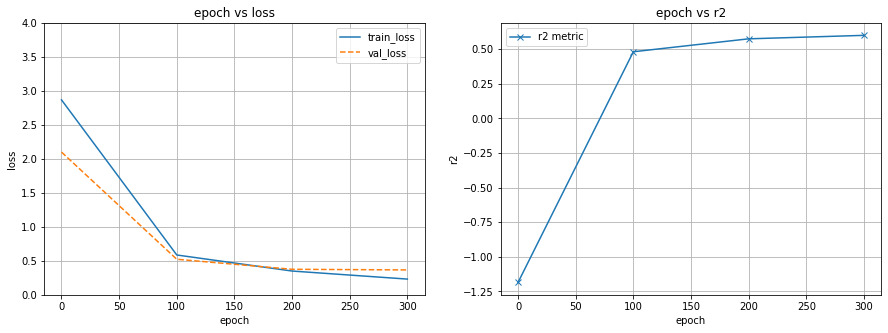

In [126]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 4.0)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_epoch, list_r2, marker='x', label='r2 metric')

ax2.set_xlabel('epoch')
ax2.set_ylabel('r2')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs r2')


plt.show()

In [124]:
#test 데이터셋의 RMSE와 R2점수 구하기 
print("RMSE: {0:.3f}".format(torch.sqrt(torch.mean(( y_test - y_pred_test )**2)).item()))
print("r2_score: {0:.3f}".format(r2_score(y_test.detach().cpu().clone() , y_pred_test.detach().cpu().clone())))

RMSE: 0.350
r2_score: 0.900


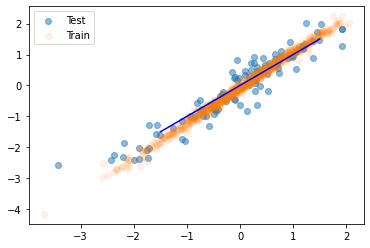

In [125]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()
    
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")